In [19]:
import mdtraj as md
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

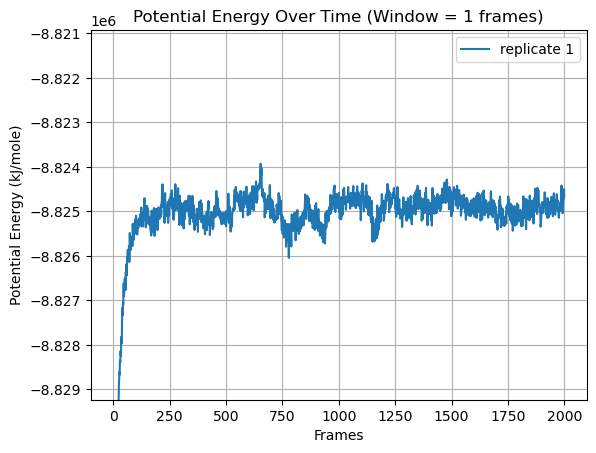

[array([-8834167.62381441, -8833370.42098678, -8833137.65286299, ...,
        -8824717.37090021, -8824501.24241351, -8824648.0773505 ],
       shape=(2000,))]

In [5]:
def plot_potential_energy(md_platform, state_file_list, plot_type, window):
    energy_arrays = []
    labels = []
    for i, state_file in enumerate(state_file_list):
        if md_platform == 'openmm':
            df = pd.read_csv(state_file)
        elif md_platform == 'gromacs':
            csv_file = os.path.splitext(state_file)[0] + '.csv'
            with open(state_file, 'r') as fin, open(csv_file, 'w') as fout:
                for line in fin:
                    if not (line.startswith('@') or line.startswith('#')):
                        fout.write(','.join(line.split()) + '\n')
            #df = pd.read_csv(csv_file, header=None) #ignore the first row as initial state
            df = pd.read_csv(csv_file)
            df.columns = ['time', 'Potential Energy (kJ/mole)']
        energy = df['Potential Energy (kJ/mole)'].to_numpy()
        n_windows = len(energy) // window
        avg_energy = np.array([energy[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        energy_arrays.append(avg_energy)
        labels.append(f'replicate {i+1}')
        if plot_type == 'line':
            plt.plot(avg_frames, avg_energy, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('Potential Energy (kJ/mole)')
            plt.title(f'Potential Energy Over Time (Window = {window} frames)')
            plt.ylim(np.mean(energy) - 5*np.std(energy), np.mean(energy) + 5*np.std(energy))
        elif plot_type == 'hist':
            sns.kdeplot(avg_energy, label=labels[-1])
            plt.xlabel('Potential Energy (kJ/mole)')
            plt.title('Potential Energy Distribution')
            plt.xlim(np.mean(energy) - 5*np.std(energy), np.mean(energy) + 5*np.std(energy))
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    return energy_arrays

plot_potential_energy('openmm', ['old_ANI2x/data.csv'], 'line', 1)

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


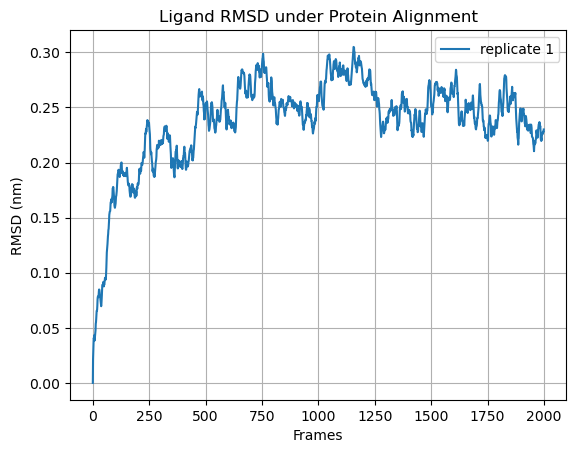

In [12]:
def plot_rmsd_fluctuations_multiple(traj_files, top_file, plot_type, window, saved_file_paths):
    rmsd_arrays = []
    labels = []
    for i, traj_file in enumerate(traj_files):
        traj = md.load(traj_file, top=top_file)
        traj.image_molecules(inplace=True)
        frames = np.arange(0, traj.n_frames)
        ligand_atoms = traj.topology.select('resname UNK')
        traj.superpose(traj, frame=0, atom_indices=ligand_atoms)
        traj.save(saved_file_paths[i])
        result = traj.xyz[:, ligand_atoms, :] - traj.xyz[0, ligand_atoms, :]
        ligand_rmsd = np.sqrt((result ** 2).sum(axis=-1).mean(axis=-1))
        n_windows = len(ligand_rmsd) // window
        avg_rmsd = np.array([ligand_rmsd[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        rmsd_arrays.append(avg_rmsd)
        labels.append(f'replicate {i+1}')
        if plot_type == 'line':
            plt.plot(avg_frames, avg_rmsd, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('RMSD (nm)')
            plt.title(f'Ligand RMSD under Protein Alignment')
        elif plot_type == 'hist':
            sns.kdeplot(avg_rmsd, label=labels[-1])
            plt.xlabel('RMSD (nm)')
            plt.title('Ligand RMSD Distribution under Protein Alignment')
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    return traj

trj = plot_rmsd_fluctuations_multiple(['old_ANI2x/test_ani_mixed.dcd'], 'old_ANI2x/gaff_ligand_in_solvent.pdb', 'line', 1, ['old_ANI2x/processed.xtc'])

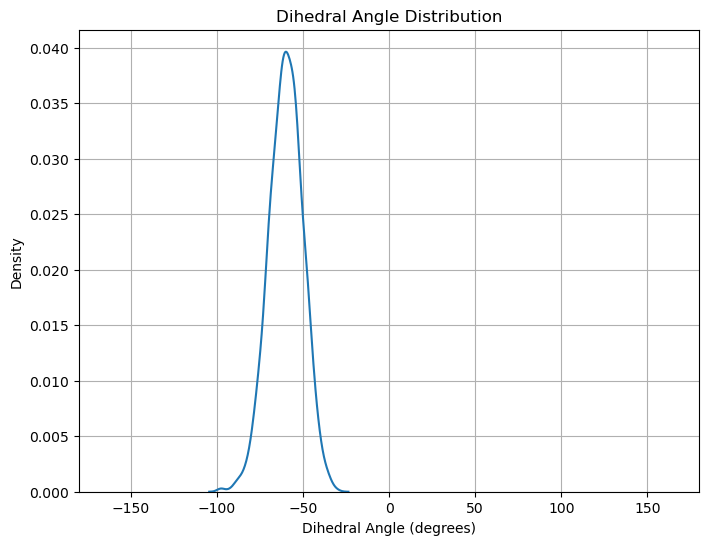

np.float32(-59.98285)

In [13]:
def plot_dihedral_angles(traj_cont, atom_indices):
    dihedral_angles = md.compute_dihedrals(traj_cont, [atom_indices])
    dihedral_angles_deg = np.degrees(dihedral_angles[:, 0])
    plt.figure(figsize=(8, 6))
    sns.kdeplot(dihedral_angles_deg)
    plt.xlabel('Dihedral Angle (degrees)')
    plt.ylabel('Density')
    plt.title('Dihedral Angle Distribution')
    plt.xlim(-180, 180)
    plt.grid(True)
    plt.show()
    plt.close()
    return np.mean(dihedral_angles_deg)

plot_dihedral_angles(trj, [11, 10, 9, 4])

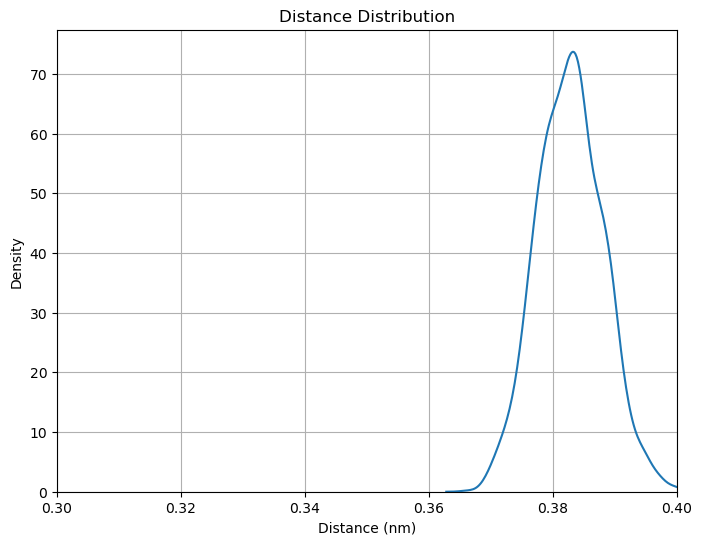

np.float32(0.38278145)

In [14]:
def plot_distance(traj_cont, atom_indices):
    atom_pairs = np.array([atom_indices])
    distances = md.compute_distances(traj_cont, atom_pairs)
    distance = distances[:, 0]
    plt.figure(figsize=(8, 6))
    sns.kdeplot(distance)
    plt.xlabel('Distance (nm)')
    plt.ylabel('Density')
    plt.title('Distance Distribution')
    plt.xlim(0.3, 0.4)
    plt.grid(True)
    plt.show()
    plt.close()
    return np.mean(distance)

plot_distance(trj, [55, 58])

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


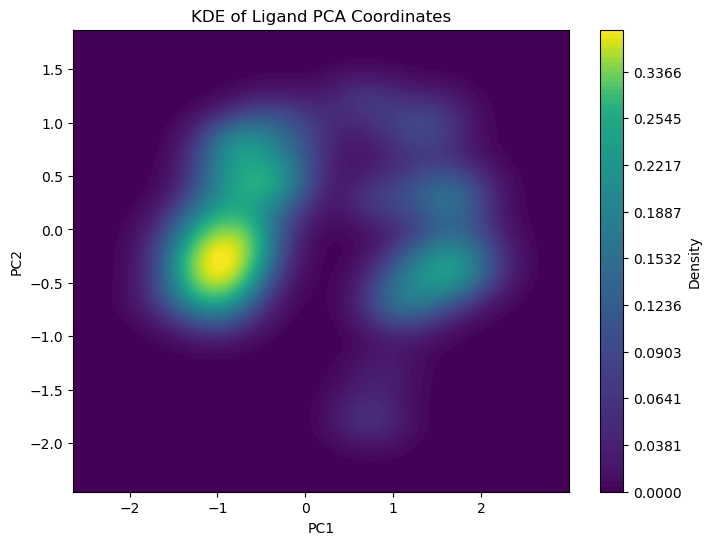

<mdtraj.Trajectory with 2000 frames, 5050 atoms, 1634 residues, and unitcells at 0x7facff55cd50>

In [20]:
def plot_ligand_pca(traj_files, top_file, slice_step=1):
        traj_cont = md.load(traj_files[0], top=top_file)[::slice_step]
        for i, traj_file in enumerate(traj_files[1:]):
                traj = md.load(traj_file, top=top_file)[::slice_step]
                traj_cont = md.join([traj_cont, traj])

        traj_cont.image_molecules(inplace=True)

        ligand_atoms = traj_cont.topology.select('resname UNK')
        traj_cont.superpose(traj_cont, frame=0, atom_indices=ligand_atoms)
        ligand_xyz = traj_cont.xyz[:, ligand_atoms, :]
        ligand_xyz_flat = ligand_xyz.reshape(traj_cont.n_frames, len(ligand_atoms) * 3)
        pca1 = PCA(n_components=2)
        reduced_cartesian = pca1.fit_transform(ligand_xyz_flat)
        plt.figure(figsize=(8, 6))
        kde = sns.kdeplot(
                x=reduced_cartesian[:, 0],
                y=reduced_cartesian[:, 1],
                fill=True,
                cmap="viridis",
                thresh=0,
                levels=100
        )
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('KDE of Ligand PCA Coordinates')
        mappable = kde.collections[0]
        plt.colorbar(mappable, label='Density')
        plt.show()
        plt.close()
        return traj_cont

plot_ligand_pca(['old_ANI2x/test_ani_mixed.dcd'], 'old_ANI2x/gaff_ligand_in_solvent.pdb')

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


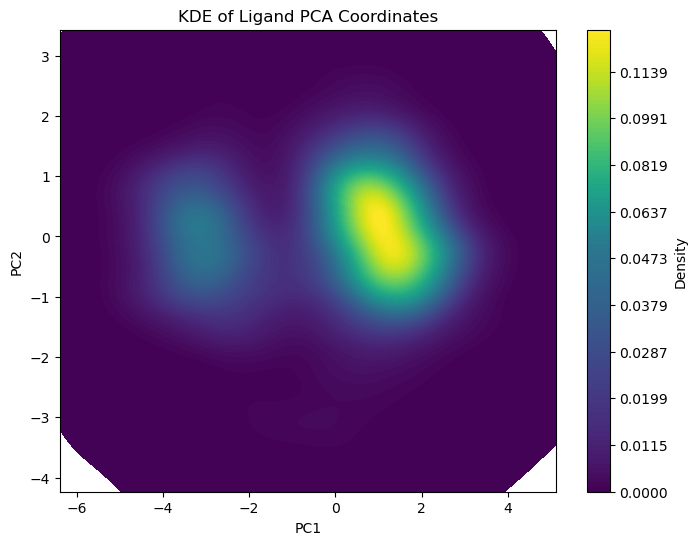

<mdtraj.Trajectory with 1000 frames, 5050 atoms, 1634 residues, and unitcells at 0x7faca1547050>

In [22]:
plot_ligand_pca(['classic_gaff/trajectory.dcd'], 'classic_gaff/gaff_ligand_in_solvent.pdb')

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


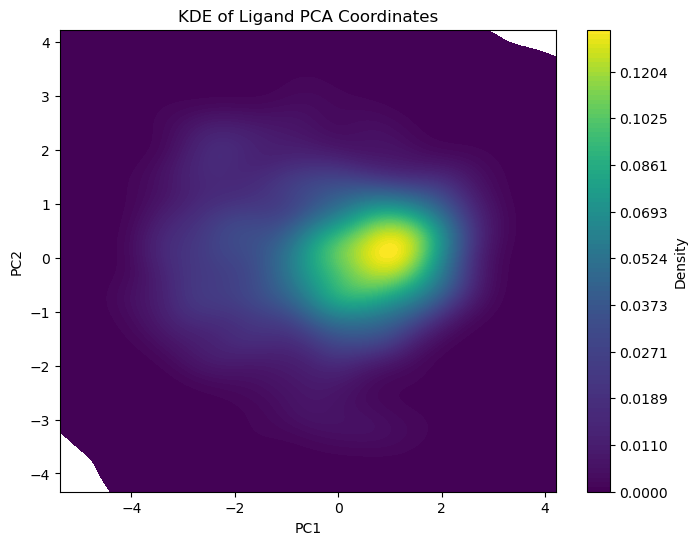

<mdtraj.Trajectory with 1000 frames, 5047 atoms, 1633 residues, and unitcells at 0x7facbc23fd10>

In [23]:
plot_ligand_pca(['classic_sage/trajectory.dcd'], 'classic_sage/ligand_in_solvent.pdb')

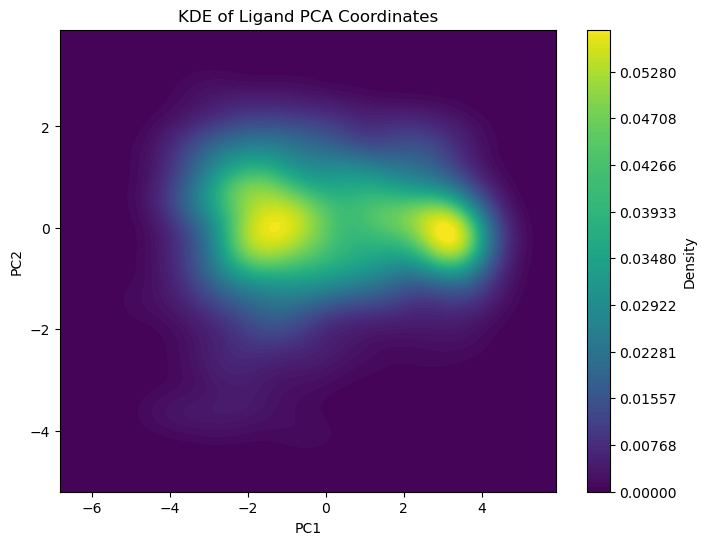

<mdtraj.Trajectory with 1001 frames, 5047 atoms, 1633 residues, and unitcells at 0x7fac9fd4c090>

In [25]:
plot_ligand_pca(['../REMD/REMD_2/0_sorted_md_pbc_fit.xtc'], '../ligand_in_solvent.pdb')

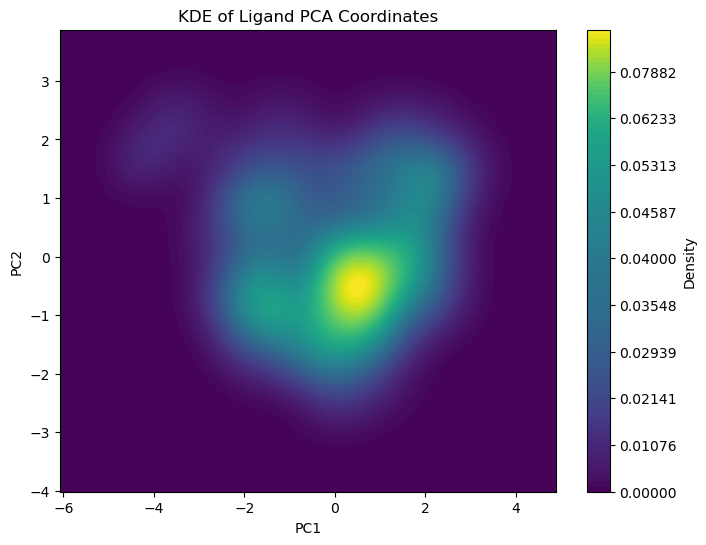

<mdtraj.Trajectory with 501 frames, 151 atoms, 1 residues, without unitcells at 0x7faca01c4cd0>

In [29]:
def plot_REST_ligand_pca(traj_files, top_file, slice_step=1):
        traj_cont = md.load(traj_files[0], top=top_file)[::slice_step]
        for i, traj_file in enumerate(traj_files[1:]):
                traj = md.load(traj_file, top=top_file)[::slice_step]
                traj_cont = md.join([traj_cont, traj])

        #traj_cont.image_molecules(inplace=True)

        ligand_atoms = traj_cont.topology.select('resname UNK')
        traj_cont.superpose(traj_cont, frame=0, atom_indices=ligand_atoms)
        ligand_xyz = traj_cont.xyz[:, ligand_atoms, :]
        ligand_xyz_flat = ligand_xyz.reshape(traj_cont.n_frames, len(ligand_atoms) * 3)
        pca1 = PCA(n_components=2)
        reduced_cartesian = pca1.fit_transform(ligand_xyz_flat)
        plt.figure(figsize=(8, 6))
        kde = sns.kdeplot(
                x=reduced_cartesian[:, 0],
                y=reduced_cartesian[:, 1],
                fill=True,
                cmap="viridis",
                thresh=0,
                levels=100
        )
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('KDE of Ligand PCA Coordinates')
        mappable = kde.collections[0]
        plt.colorbar(mappable, label='Density')
        plt.show()
        plt.close()
        return traj_cont

plot_REST_ligand_pca(['../REST/REST_2/replica_0_ligand_samples.pdb'], '../REST/ligand.pdb')